# Importing Packages

In [1]:
from pyblock2.driver.core import DMRGDriver, SymmetryTypes, MPOAlgorithmTypes
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Functions for Constructing Matrices

In [2]:
def vector_to_hermitian(upper_triangle_vector):
    # Check if the input vector is real-valued or complex-valued
    is_real = np.isrealobj(upper_triangle_vector)
    
    # Determine the size of the matrix (n x n)
    n = int(np.sqrt(2 * len(upper_triangle_vector) + 0.25) - 0.5)
    
    # Initialize an empty matrix with the appropriate type
    dtype = float if is_real else complex
    A = np.zeros((n, n), dtype=dtype)
    
    # Fill in the upper triangle
    indices = np.triu_indices(n)
    A[indices] = upper_triangle_vector
    
    # Assign values to the lower triangle
    i_lower = np.tril_indices(n, -1)
    if is_real:
        A[i_lower] = A.T[i_lower]  # Copy upper triangle values to lower triangle
    else:
        A[i_lower] = np.conj(A.T[i_lower])  # Assign conjugate transpose to lower triangle
    
    return A

# Definitions

In [3]:
params = {}
params['L'], params['N'], params['nmax'] = 64, 64, 4
# params['L1'], params['L2'], params['L3'] = 31, 33, 64 
params['L1'], params['L2'], params['L3'] = 30, 34, 64 
params['t'], params['U1'], params['U2'], params['U3'] = 1.0, 2, 2, 2

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SAny, n_threads=4)

driver.set_symmetry_groups("U1")
Q = driver.bw.SX

In [4]:
# [Part A] Set states and matrix representation of operators in local Hilbert space
site_basis, site_ops = [], []

# # Definig Operators
# bdag = np.diag(np.sqrt(np.arange(1, params['nmax'] + 1)), k=-1) # b+
# b = bdag.T # b

# adag = np.diag([np.sqrt(n+1) * (-1)**n for n in range(params['nmax'])], -1) # a+ = b+ exp(i*n*pi)
# a = adag.T # a

# Define Bosonic Operators (Region 1 and Region 3)
bdag = np.diag(np.sqrt(np.arange(1, params['nmax'] + 1)), k=-1)  # b+ (bosonic creation)
b = bdag.T  # b (bosonic annihilation)

# Define Pseudofermionic Operators (Region 2)
adag = np.diag([np.sqrt(n+1) * (-1)**n for n in range(params['nmax'])], -1)  # a+ = b+ exp(i*n*pi)
a = adag.T  # a

n = np.diag(np.arange(0, params['nmax'] + 1), k=0) # particle number 

for k in range(params['L']):
    basis = [(Q(i), 1) for i in range(params['nmax'] + 1)] 
    ops = {
        "": np.identity(params['nmax'] + 1), # identity
        "C": bdag, # b+
        "D": b,  # b
        "A": adag, # a+
        "B": a, # a
        "N": n, # particle number         
    }
    site_basis.append(basis)
    site_ops.append(ops)

# Setting Up Hamiltonian

In [5]:
# Initialize DMRG system
driver.initialize_system(n_sites=params['L'], vacuum=Q(0), target=Q(params['N']), hamil_init=False)
driver.ghamil = driver.get_custom_hamiltonian(site_basis, site_ops)
b = driver.expr_builder()

# Region 1: Bosonic Operators
for i in range(0, params['L1'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U1'] / 2)  # Onsite interaction
    b.add_term("CD", [i, i], -params['U1'] / 2)  # Chemical potential

for i in range(0, params['L1'] - 1, 1):
    b.add_term("CD", [i, i + 1], -params['t'])  # Hopping term
    b.add_term("CD", [i + 1, i], -params['t'])  # Hopping term

# Region 2: Pseudofermionic Operators
for i in range(params['L1'], params['L2'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U2'] / 2)  # Onsite interaction
    b.add_term("CD", [i, i], -params['U2'] / 2)  # Chemical potential

for i in range(params['L1'], params['L2'] - 1, 1):
    b.add_term("AD", [i, i + 1], -params['t'])  # Hopping with pseudofermions
    b.add_term("CB", [i + 1, i], -params['t'])  # Hopping with pseudofermions

# Region 3: Bosonic Operators
for i in range(params['L2'], params['L3'], 1):
    b.add_term("CCDD", [i, i, i, i], params['U3'] / 2)  # Onsite interaction
    b.add_term("CD", [i, i], -params['U3'] / 2)  # Chemical potential

for i in range(params['L2'], params['L3'] - 1, 1):
    b.add_term("CD", [i, i + 1], -params['t'])  # Hopping term
    b.add_term("CD", [i + 1, i], -params['t'])  # Hopping term


In [6]:
# [Part C] Perform DMRG

start_time = time.time()
#########################################

mpo = driver.get_mpo(b.finalize(adjust_order=True, fermionic_ops=""), algo_type=MPOAlgorithmTypes.FastBipartite)

mps = driver.get_random_mps(tag="KET", bond_dim=50, nroots=1, occs=[1] * params['L'])
energy = driver.dmrg(
    mpo, 
    mps, 
    n_sweeps=100, 
    bond_dims=[50] * 10 + [100] * 5 + [200] * 5 + [500] * 5 + [1000] * 5, 
    noises=[1e-3] * 3 + [1e-5] * 3 + [0],  
    thrds=[1e-10] * 20, 
    dav_max_iter=100, 
    tol=1e-10, 
    iprint=1)
print("Final bond dimension =", mps.info.get_max_bond_dimension())

#########################################
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")



Sweep =    0 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      0.324 | E =    -141.6471111431 | DW = 6.90344e-11

Sweep =    1 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.001 | E =    -141.9909614636 | DE = -3.44e-01 | DW = 3.56300e-08

Sweep =    2 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-03 | Dav threshold =  1.00e-10
Time elapsed =      1.492 | E =    -141.9922456015 | DE = -1.28e-03 | DW = 1.33876e-07

Sweep =    3 | Direction = backward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.672 | E =    -141.9922567296 | DE = -1.11e-05 | DW = 6.11942e-08

Sweep =    4 | Direction =  forward | Bond dimension =   50 | Noise =  1.00e-05 | Dav threshold =  1.00e-10
Time elapsed =      1.808 | E =    -141.9922573855 | DE = -6.56e-07 | DW = 6.99268e-08

Sweep =    5 | Direction = backward 

## <font color='blue'>Evolution over sweeps</font>

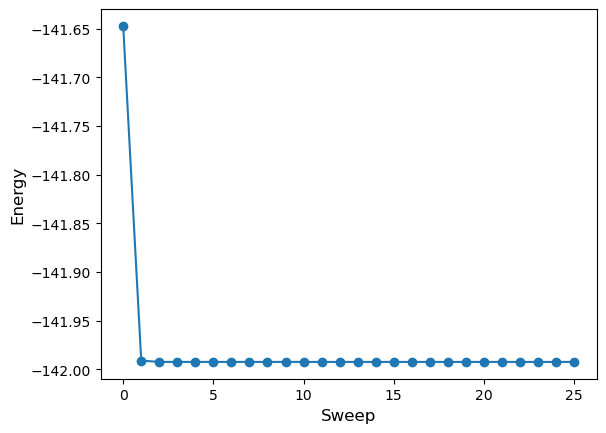

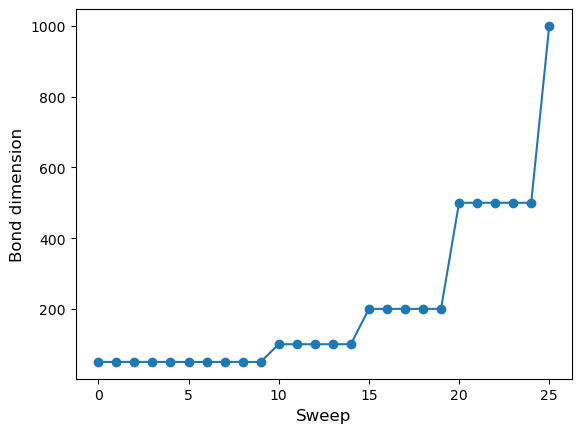

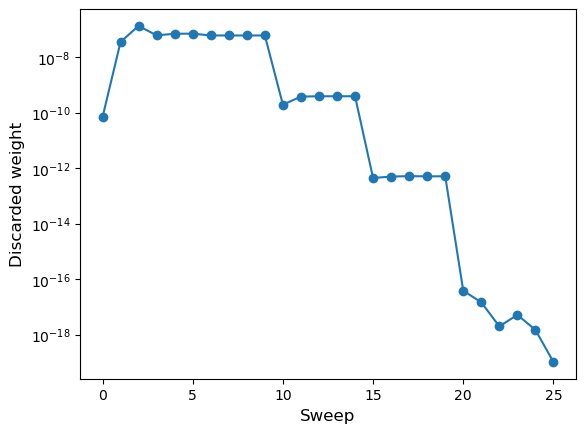

In [7]:
bonddims, discardedweights, energies = driver.get_dmrg_results()
plt.plot(energies.flatten(), marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.show()
plt.plot(bonddims, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Bond dimension', fontsize=12)
plt.show()
plt.plot(discardedweights, marker='o')
plt.xlabel('Sweep', fontsize=12)
plt.ylabel('Discarded weight', fontsize=12)
plt.yscale('log')
plt.show()

## <font color='blue'>Entanglement</font>

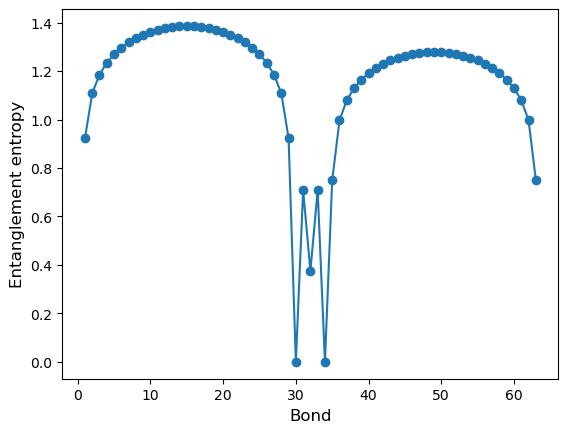

In [8]:
SvN = driver.get_bipartite_entanglement()

plt.plot(np.arange(1,params['L']), SvN, marker='o')
plt.xlabel('Bond', fontsize=12)
plt.ylabel('Entanglement entropy', fontsize=12)
plt.show()

## <font color='blue'>Single-particle boson correlations</font>

### Calculate

In [9]:
start_time = time.time()

bosoncorr_mat = driver.get_npdm(mps, npdm_expr='CD', fermionic_ops='', mask=[0, 1])[0]
navg = np.diag(bosoncorr_mat)
print("Total number =", sum(navg))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Total number = 63.99999999999992
Elapsed time: 3.2543184757232666 seconds


### Site occupations

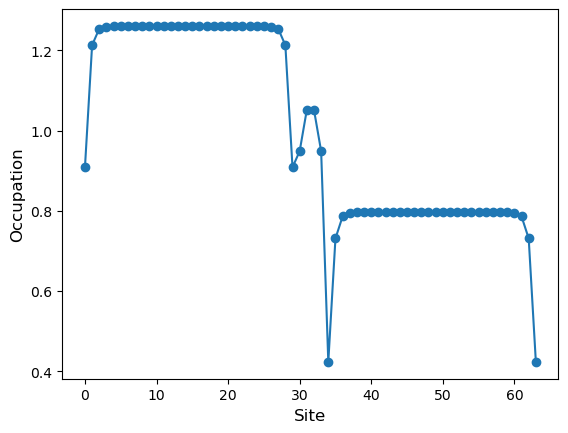

In [10]:
plt.plot(np.arange(params['L']), navg, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Occupation', fontsize=12)
plt.show()

### Correlation matrix

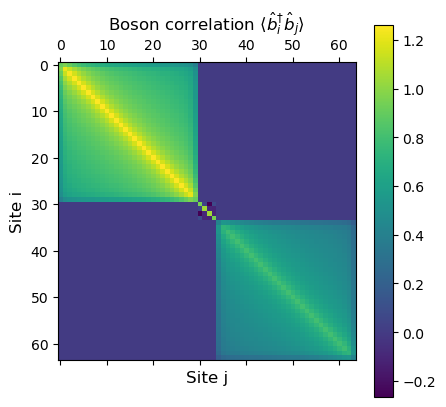

In [11]:
plt.matshow(bosoncorr_mat, cmap='viridis', vmin=bosoncorr_mat.min(), vmax=bosoncorr_mat.max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Boson correlation $\langle \hat{b}_{i}^{\dagger} \hat{b}_{j} \rangle$')
plt.show()

### Correlation vs distance

/tmp/ipykernel_71895/3195062755.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


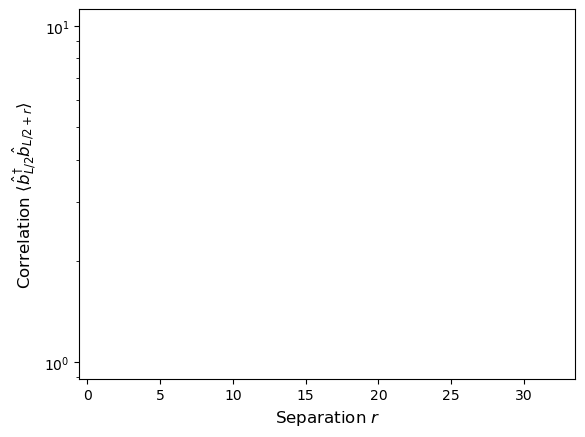

In [12]:
plt.plot(np.arange(1,params['L']//2+1), bosoncorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $\langle \hat{b}_{L/2}^{\dagger} \hat{b}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()

## <font color='blue'>On-site number distribution</font>

### Calculate

In [17]:
start_time = time.time()

ndist = np.array(driver.get_npdm(mps, npdm_expr=proj_keys, fermionic_ops='')).T
print("Deviation from unit filling =", np.linalg.norm([ndist[i].sum()-1 for i in range(params['L'])]))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

NameError: name 'proj_keys' is not defined

### Site-averaged number distribution

In [ ]:
plt.plot(np.mean(ndist, axis=0), marker='o')
plt.xlabel('$n$', fontsize=12)
plt.ylabel('Site-avgd distribution $p(n)$', fontsize=12)
plt.yscale('linear')
plt.show()

### Number fluctuation

In [ ]:
nsqavg = np.array([np.dot(np.arange(params['nmax']+1)**2, ndist[i]) for i in range(params['L'])])
numfluc = np.sqrt(nsqavg - navg*navg)
plt.plot(np.arange(params['L']), numfluc, marker='o')
plt.xlabel('Site', fontsize=12)
plt.ylabel('Number fluctuation', fontsize=12)
plt.title(f"Avg = {np.mean(numfluc)}")
plt.show()

## <font color='blue'>Density-density correlations</font>

### Calculate

In [13]:
start_time = time.time()

nnexp_mat = driver.get_npdm(mps, npdm_expr='CDCD', fermionic_ops='', mask=[0, 0, 1, 1])[0]
densitycorr_mat = nnexp_mat - np.outer(navg, navg)
print("Avg number fluctuation =", np.mean(np.sqrt(np.diag(densitycorr_mat))))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Avg number fluctuation = 0.6948972646185627
Elapsed time: 2.293370008468628 seconds


### Correlation matrix

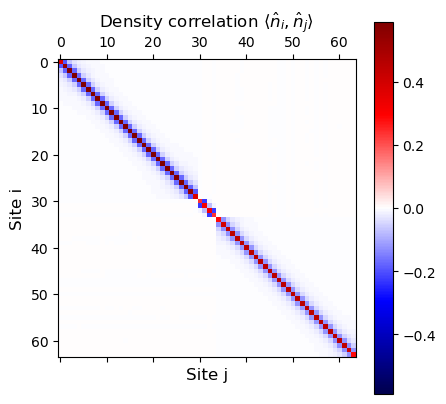

In [14]:
plt.matshow(densitycorr_mat, cmap='seismic', vmin=-np.abs(densitycorr_mat).max(), vmax=np.abs(densitycorr_mat).max())
plt.colorbar()
plt.xlabel('Site j', fontsize=12)
plt.ylabel('Site i', fontsize=12)
plt.title(r'Density correlation $\langle \hat{n}_{i}, \hat{n}_{j} \rangle$')
plt.show()

### Correlation vs distance

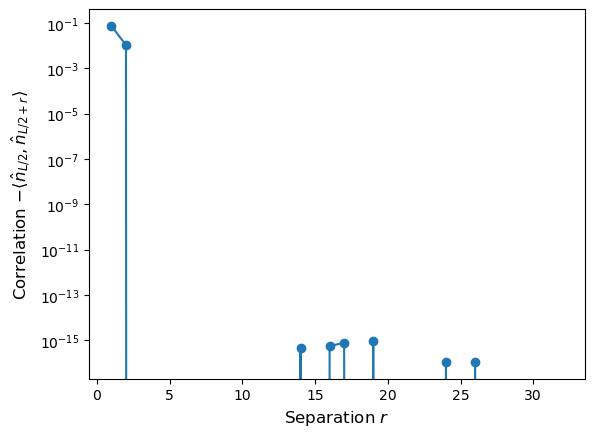

In [15]:
plt.plot(np.arange(1,params['L']//2+1), -densitycorr_mat[params['L']//2-1,params['L']//2:], marker='o')
plt.xlabel('Separation $r$', fontsize=12)
plt.ylabel(r'Correlation $-\langle \hat{n}_{L/2}, \hat{n}_{L/2+r} \rangle$', fontsize=12)
plt.yscale('log')
plt.xscale('linear')
plt.show()